In [2]:
from tensorflow.keras import models, layers
from tensorflow import keras
from data_handler import get_selected_data
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import preprocessing
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [3]:
data = get_selected_data()

In [4]:
trajectories = [tmd["traj_data"] for tmd in data]
classes = [tmd["class"] for tmd in data]

In [5]:
le = preprocessing.LabelEncoder()
le.fit(classes)
for cls, lbl in zip(le.classes_, le.transform(le.classes_)):
    print(lbl, cls)
labeled_classes = le.transform(classes)
print("\nAll classes labeled:", labeled_classes)

0 bike
1 bus
2 car
3 train
4 walk

All classes labeled: [4 2 2 ... 1 4 1]


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    trajectories, labeled_classes, stratify=labeled_classes, random_state=0, test_size=0.20,
)

X_validation, X_test, y_validation, y_test = train_test_split(
    X_test, y_test, stratify=y_test, random_state=0, test_size=0.10,
)

In [60]:
def prepare_data(trajs, cls, hist_size=75):
    X, y = [], []
    for traj, cls in zip(trajs, cls):
        X.append(traj[-hist_size:])
        y.append(cls)
    return np.array(X), np.array(y)

def plot_model_results(history):
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def save_history(model, file_name="history"):
    with open(file_name, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [79]:
last_n_points = 100
tX, ty = prepare_data(X_train, y_train, last_n_points)
vX, vy = prepare_data(X_validation, y_validation, last_n_points)
teX, tey = prepare_data(X_test, y_test, last_n_points)

In [75]:
def predict(trajs, model, hist_size=75, cls = None):
    if cls is None:
        cls = [""] * len(trajs)
    for traj, cl in zip(trajs, cls):
        X, _ = prepare_data([traj], [0], hist_size)
        pred = model.predict(X)
        print(pred[-1], np.argmax(pred[-1], axis=0), cl)

In [85]:
model = keras.Sequential()

model.add(layers.LSTM(128, input_shape=(last_n_points, 3), return_sequences=True))
model.add(layers.Bidirectional(layers.LSTM(64, input_shape=(last_n_points, 3)), merge_mode='ave'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
#               optimizer='adam',
              metrics=['accuracy'])
model.summary()


es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
mc = keras.callbacks.ModelCheckpoint('best_model_6.h5', monitor='accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(tX, ty, epochs=50, callbacks=[mc, es], validation_data=(vX, vy))

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_88 (LSTM)              (None, 100, 128)          67584     
                                                                 
 bidirectional_22 (Bidirecti  (None, 64)               98816     
 onal)                                                           
                                                                 
 dense_51 (Dense)            (None, 20)                1300      
                                                                 
 dense_52 (Dense)            (None, 5)                 105       
                                                                 
Total params: 167,805
Trainable params: 167,805
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
98/99 [============================>.] - ETA: 0s - loss: 1.4169 - accuracy: 0.4340
Epoch 1: accuracy i

99/99 [==============================] - 6s 56ms/step - loss: 1.3456 - accuracy: 0.4699 - val_loss: 1.3637 - val_accuracy: 0.4831
Epoch 27/50
98/99 [============================>.] - ETA: 0s - loss: 1.3444 - accuracy: 0.4694
Epoch 27: accuracy did not improve from 0.47400
99/99 [==============================] - 6s 57ms/step - loss: 1.3456 - accuracy: 0.4689 - val_loss: 1.3534 - val_accuracy: 0.4887
Epoch 28/50
98/99 [============================>.] - ETA: 0s - loss: 1.3401 - accuracy: 0.4729
Epoch 28: accuracy did not improve from 0.47400
99/99 [==============================] - 6s 56ms/step - loss: 1.3409 - accuracy: 0.4734 - val_loss: 1.3936 - val_accuracy: 0.4606
Epoch 29/50
98/99 [============================>.] - ETA: 0s - loss: 1.3442 - accuracy: 0.4713
Epoch 29: accuracy did not improve from 0.47400
99/99 [==============================] - 6s 58ms/step - loss: 1.3438 - accuracy: 0.4711 - val_loss: 1.3680 - val_accuracy: 0.4817
Epoch 30/50
98/99 [============================>.] 

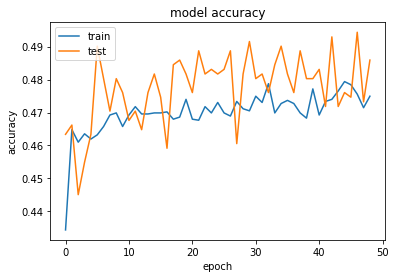

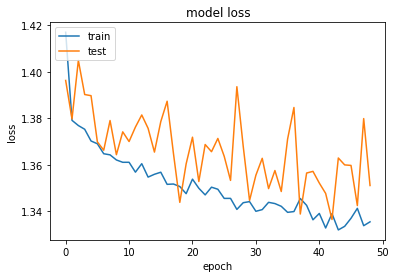

In [86]:
save_history(history.history, "history_6")
plot_model_results(history.history)

In [87]:
print(model.evaluate(teX, tey))
print()
predict(X_test[:20], model, last_n_points, y_test[:20])

3/3 [==============================] - 0s 15ms/step - loss: 1.4142 - accuracy: 0.4810
[1.414246678352356, 0.4810126721858978]

1/1 [==============================] - 1s 542ms/step
[0.07966072 0.19872272 0.08383705 0.06065995 0.5771195 ] 4 0
1/1 [==============================] - 0s 14ms/step
[0.52509344 0.16628724 0.1085192  0.02565575 0.17444435] 0 0
1/1 [==============================] - 0s 14ms/step
[0.12753877 0.4872439  0.15415025 0.07221349 0.15885365] 1 4
1/1 [==============================] - 0s 15ms/step
[0.28797206 0.20560323 0.09735233 0.05365917 0.3554132 ] 4 4
1/1 [==============================] - 0s 14ms/step
[0.12871745 0.4862645  0.15344015 0.07255966 0.15901834] 1 0
1/1 [==============================] - 0s 15ms/step
[0.17462045 0.21244402 0.07796657 0.04137617 0.49359277] 4 1
1/1 [==============================] - 0s 14ms/step
[0.12438741 0.49124846 0.15666635 0.06940297 0.15829481] 1 1
1/1 [==============================] - 0s 16ms/step
[0.6053757  0.1570868  0.0906